- 모델경량화 : 교사모델(가중치가 많음), 학생모델(가중치가 적음)
- 지식증류 알고리즘 : 교사모델을 이용해서 학생모델을 학습

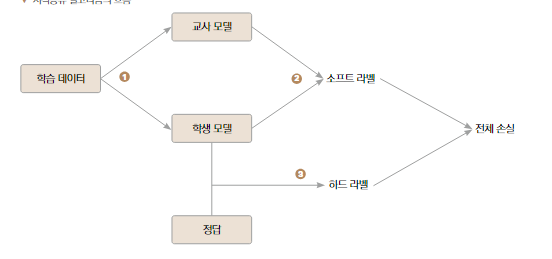

In [1]:
# CIFAR10, resnet34()
import torch
import torch.nn as nn
import tqdm

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose,ToTensor, RandomHorizontalFlip,RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader
from torchvision.models.resnet import resnet34, resnet18

from torch.optim.adam import Adam

In [2]:
# 데이터 전처리
transforms = Compose([
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    ToTensor(),
    Normalize(mean=(0.5,0.5,0.5),std=(0.2,0.2,0.2))
])

In [3]:
from torch.utils.data import DataLoader
# 학습용데이터
train_data = CIFAR10(root='./',train = True,download=True,transform=transforms)
test_data = CIFAR10(root='./',train = False,download=True,transform=transforms)

# 검증용데이터
train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
torch._tensor_str_loader = DataLoader(test_data, batch_size=32,shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

100%|██████████| 170498071/170498071 [00:03<00:00, 43686411.72it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
# 교사모델
teacher = resnet34(pretrained=False,num_classes=10)
teacher.to(device)
optim = Adam(teacher.parameters())
for epoch in range(2):
  iter = tqdm.tqdm(train_loader)
  for data,label in iter:
    optim.zero_grad()
    preds = teacher(data.to(device))
    loss = nn.CrossEntropyLoss()(preds, label.to(device))
    loss.backward()
    optim.step()
    iter.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(teacher.state_dict(),"teacher.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
epoch:1 loss:1.6342642307281494: 100%|██████████| 1563/1563 [01:09<00:00, 22.60it/s]


In [5]:
import torch.nn.functional as F

In [6]:
class Generator(nn.Module):
  def __init__(self, dims=256,channel=3) -> None:
    super(Generator,self).__init__()
    # 256->128*8*8 이미지생성
    self.l1 = nn.Sequential(nn.Linear(dims,128*8*8))
    self.conv_blocks0 = nn.Sequential(
        nn.BatchNorm2d(128)
    )
    self.conv_blocks1 = nn.Sequential(
        nn.Conv2d(128,128,3,stride=1,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU()
    )
    self.conv_blocks2 = nn.Sequential(
        nn.Conv2d(128,64,3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(64,channel,3,stride=1,padding=1),
        nn.Tanh(),
        nn.BatchNorm2d(channel)
    )
  def forward(self, x):
    x = self.l1(x.view(x.shape[0],-1))
    x = x.view(x.shape[0],-1,8,8)
    x = self.conv_blocks0(x)
    # 이미지를 두배로 늘려줌
    x = nn.functional.interpolate(x,scale_factor=2)
    x = self.conv_blocks1(x)
    x = nn.functional.interpolate(x,scale_factor=2)
    x = self.conv_blocks2(x)
    return x

# 학생모델과 생성자 학습

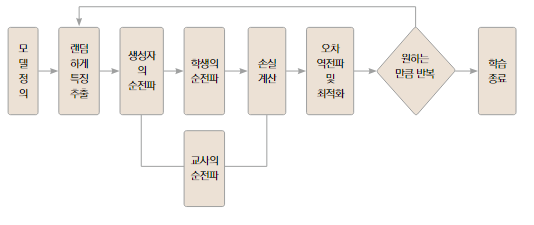

In [7]:
# 교사모델
teacher = resnet34(pretrained=False,num_classes=10)
teacher.load_state_dict(torch.load('./teacher.pth',map_location=device))
teacher.to(device)
teacher.eval()

# 학생
student = resnet18(pretrained=False,num_classes=10)
student.to(device)

#생성자
generator = Generator().to(device)

from torch.optim.sgd import SGD
# 생성자는 Adam으로, 학생은 SGD를 이용해서 학습
# Adam은 학습속도가 빠르고 SGD는 과적합을 피하는데유리
G_optim = Adam(generator.parameters())
S_optim = SGD(student.parameters(), lr = 0.1)

In [8]:
for epoch in range(2):
  # 확인 : 학생은 5번 생성자는 5번 가중치 학습 -> 생성자가 너무 빨리학습되면 학생이 학습못함
  for _ in range(5):
    noise = torch.randn(256,256,1,1,device=device)
    S_optim.zero_grad()
    #이미지  생성
    fake = generator(noise).detach()
    # 교사예측
    teacher_output  = teacher(fake)
    # 학생예측
    student_output = student(fake)
    # 교사와 학생간의 오차
    S_loss = nn.L1Loss()(student_output,teacher_output)
    #오차 역전파
    S_loss.backward()
    S_optim.step()
    print(f"epoch:{epoch} S_loss:{S_loss.item()}")



    # 생성자 학습
    noise = torch.randn(256,256,1,1,device=device)
    G_optim.zero_grad()
    fake = generator(noise).detach()
    teacher_output  = teacher(fake)
    student_output = student(fake)
    # 생성자의 오차
    G_loss = -1*nn.L1Loss()(student_output,teacher_output)
    G_loss.backward()
    G_optim.step()
    print(f"epoch:{epoch} S_loss:{G_loss.item()}")

epoch:0 S_loss:1.4669344425201416
epoch:0 S_loss:-1.4585503339767456
epoch:0 S_loss:1.4618936777114868
epoch:0 S_loss:-1.5300546884536743
epoch:0 S_loss:1.5181312561035156
epoch:0 S_loss:-1.5206407308578491
epoch:0 S_loss:1.537591576576233
epoch:0 S_loss:-1.5550222396850586
epoch:0 S_loss:1.5377073287963867
epoch:0 S_loss:-1.5070656538009644
epoch:1 S_loss:1.4944372177124023
epoch:1 S_loss:-1.5178279876708984
epoch:1 S_loss:1.5240923166275024
epoch:1 S_loss:-1.525343656539917
epoch:1 S_loss:1.4974305629730225
epoch:1 S_loss:-1.5116056203842163
epoch:1 S_loss:1.4799768924713135
epoch:1 S_loss:-1.520235300064087
epoch:1 S_loss:1.4782823324203491
epoch:1 S_loss:-1.5694868564605713


In [9]:
# 성능평가
num_corr = 0
# student.load_state_dict(torch.load('student.pth'))
# 학습용 데이터
with torch.no_grad():
  for data, label in train_loader:
    output = student(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr
  print(f"accuracy:{num_corr / len(train_data)}")

accuracy:0.10088
